In [2]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KernelDensity
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# KDE

In [3]:
class KDEEstimator(BaseEstimator):
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth
    def fit(self, X, y=None):
        X = np.atleast_2d(X)
        self.X_, self.n_, self.d_ = X, X.shape[0], X.shape[1]
        self.const_ = (2*np.pi)**(-self.d_/2)
        return self
    def _gauss(self, u):
        return self.const_ * np.exp(-0.5*np.sum(u**2, axis=-1))
    def score_samples(self, X):
        X = np.atleast_2d(X)
        u = (X[:,None,:] - self.X_[None,:,:]) / self.bandwidth
        dens = self._gauss(u).mean(axis=1) / self.bandwidth**self.d_
        return np.log(dens)
    def sample(self, n):
        idx = np.random.choice(self.n_, n, replace=True)
        noise = np.random.normal(scale=self.bandwidth,
                                 size=(n, self.d_))
        return self.X_[idx] + noise

In [4]:
np.random.seed(42)

# Смесь гауссиан в 2D
means = np.array([[0, 0], [3, 3], [-3, 3]])
covs = np.array([[[1, 0.3], [0.3, 1]],
                 [[0.5, 0.0], [0.0, 0.5]],
                 [[1, -0.2], [-0.2, 1]]])
weights = np.array([0.4, 0.35, 0.25])


def sample_mixture(n):
    idx = np.random.choice(len(weights), size=n, p=weights)
    return np.array([np.random.multivariate_normal(means[i], covs[i]) for i in idx])


X_train_kde = sample_mixture(500)
X_test_kde = sample_mixture(1000)

bandwidth = 0.7
kde_custom = KDEEstimator(bandwidth=bandwidth).fit(X_train_kde)
kde_sklearn = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(X_train_kde)

ll_custom = kde_custom.score_samples(X_test_kde)
ll_sklearn = kde_sklearn.score_samples(X_test_kde)

df_kde_syn = pd.DataFrame({
    "Model": ["Custom KDE", "sklearn KDE"],
    "Avg log-likelihood": [ll_custom.mean(), ll_sklearn.mean()]
})

In [5]:
df_kde_syn

,Model,Avg log-likelihood
0,Custom KDE,-3.737589
1,sklearn KDE,-3.737589


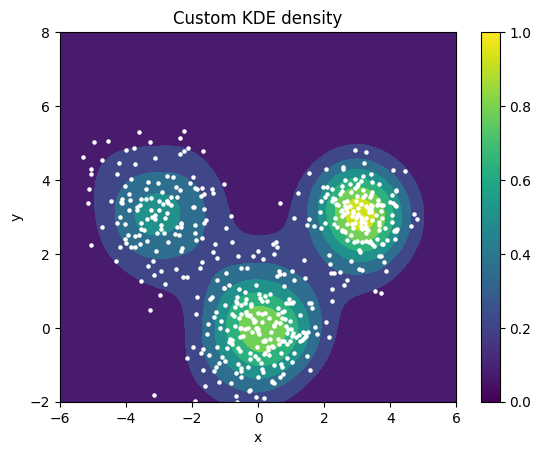

In [8]:
grid_x, grid_y = np.meshgrid(np.linspace(-6, 6, 100),
                             np.linspace(-2, 8, 100))
grid = np.c_[grid_x.ravel(), grid_y.ravel()]

z_custom = np.exp(kde_custom.score_samples(grid)).reshape(grid_x.shape)
z_sklearn = np.exp(kde_sklearn.score_samples(grid)).reshape(grid_x.shape)

plt.figure()
plt.contourf(grid_x, grid_y, z_custom, cmap='viridis')
plt.title("Custom KDE density")
plt.scatter(X_train_kde[:, 0], X_train_kde[:, 1], s=5, color='white')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

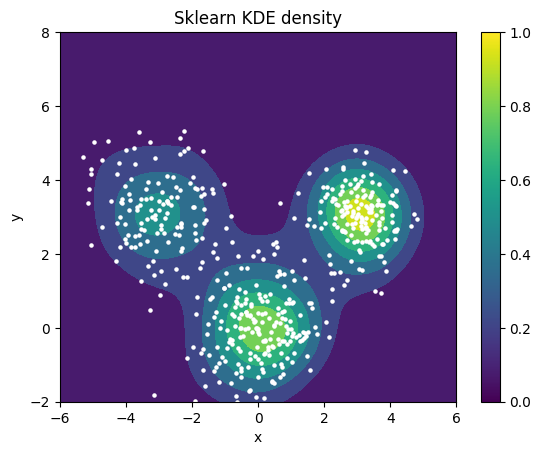

In [9]:
plt.figure()
plt.contourf(grid_x, grid_y, z_sklearn, cmap='viridis')
plt.title("Sklearn KDE density")
plt.scatter(X_train_kde[:, 0], X_train_kde[:, 1], s=5, color='white')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# Radial basis kernel regression

In [10]:
class RBFKernelRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, alpha=1e-3):
        self.gamma, self.alpha = gamma, alpha
    def _K(self, A, B):
        sq = np.sum(A**2,1)[:,None]+np.sum(B**2,1)[None,:]-2*A@B.T
        return np.exp(-self.gamma*sq)
    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.X_ = X
        K = self._K(X,X)
        self.coef_ = np.linalg.solve(K+self.alpha*np.eye(len(K)), y)
        return self
    def predict(self, X):
        return self._K(np.asarray(X), self.X_) @ self.coef_

In [11]:
X_train_reg = np.random.uniform(-3, 3, size=(100, 1))
y_train_reg = np.sin(X_train_reg[:, 0]) + 0.1 * np.random.randn(100)

X_test_reg = np.linspace(-3, 3, 200)[:, None]
y_test_reg = np.sin(X_test_reg[:, 0])

gamma = 1.0
alpha = 1e-3
rbf_custom = RBFKernelRegressor(gamma=gamma, alpha=alpha).fit(X_train_reg, y_train_reg)
rbf_sklearn = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha).fit(X_train_reg, y_train_reg)

y_pred_custom = rbf_custom.predict(X_test_reg)
y_pred_sklearn = rbf_sklearn.predict(X_test_reg)

mse_custom = mean_squared_error(y_test_reg, y_pred_custom)
mse_sklearn = mean_squared_error(y_test_reg, y_pred_sklearn)

df_rbf_syn = pd.DataFrame({
    "Model": ["Custom RBF", "sklearn KernelRidge"],
    "MSE": [mse_custom, mse_sklearn]
})

In [12]:
df_rbf_syn

,Model,MSE
0,Custom RBF,0.001015
1,sklearn KernelRidge,0.001015


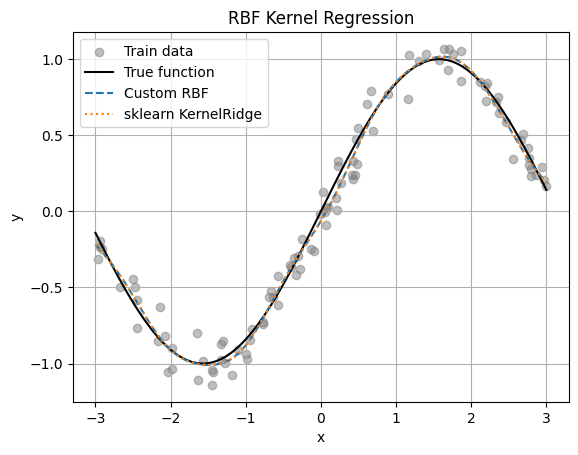

In [13]:
plt.figure()
plt.scatter(X_train_reg[:, 0], y_train_reg, label="Train data", color='gray', alpha=0.5)
plt.plot(X_test_reg[:, 0], y_test_reg, label="True function", color='black')
plt.plot(X_test_reg[:, 0], y_pred_custom, label="Custom RBF", linestyle="--")
plt.plot(X_test_reg[:, 0], y_pred_sklearn, label="sklearn KernelRidge", linestyle=":")
plt.title("RBF Kernel Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()